# < Utilizing of Pre-trained Models >

License: BSD

Author: Sasank Chilamkurthy

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751

## 0. Strategies

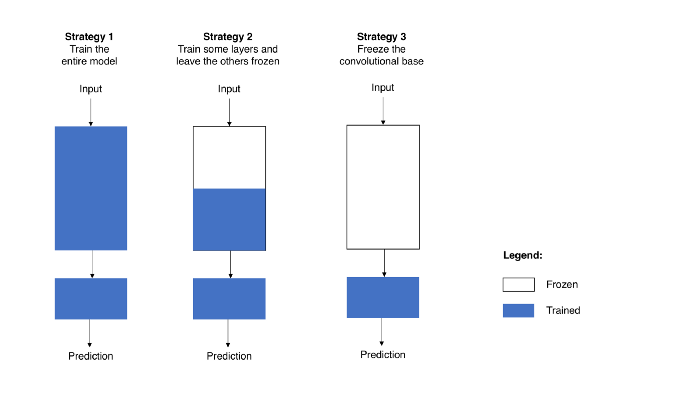

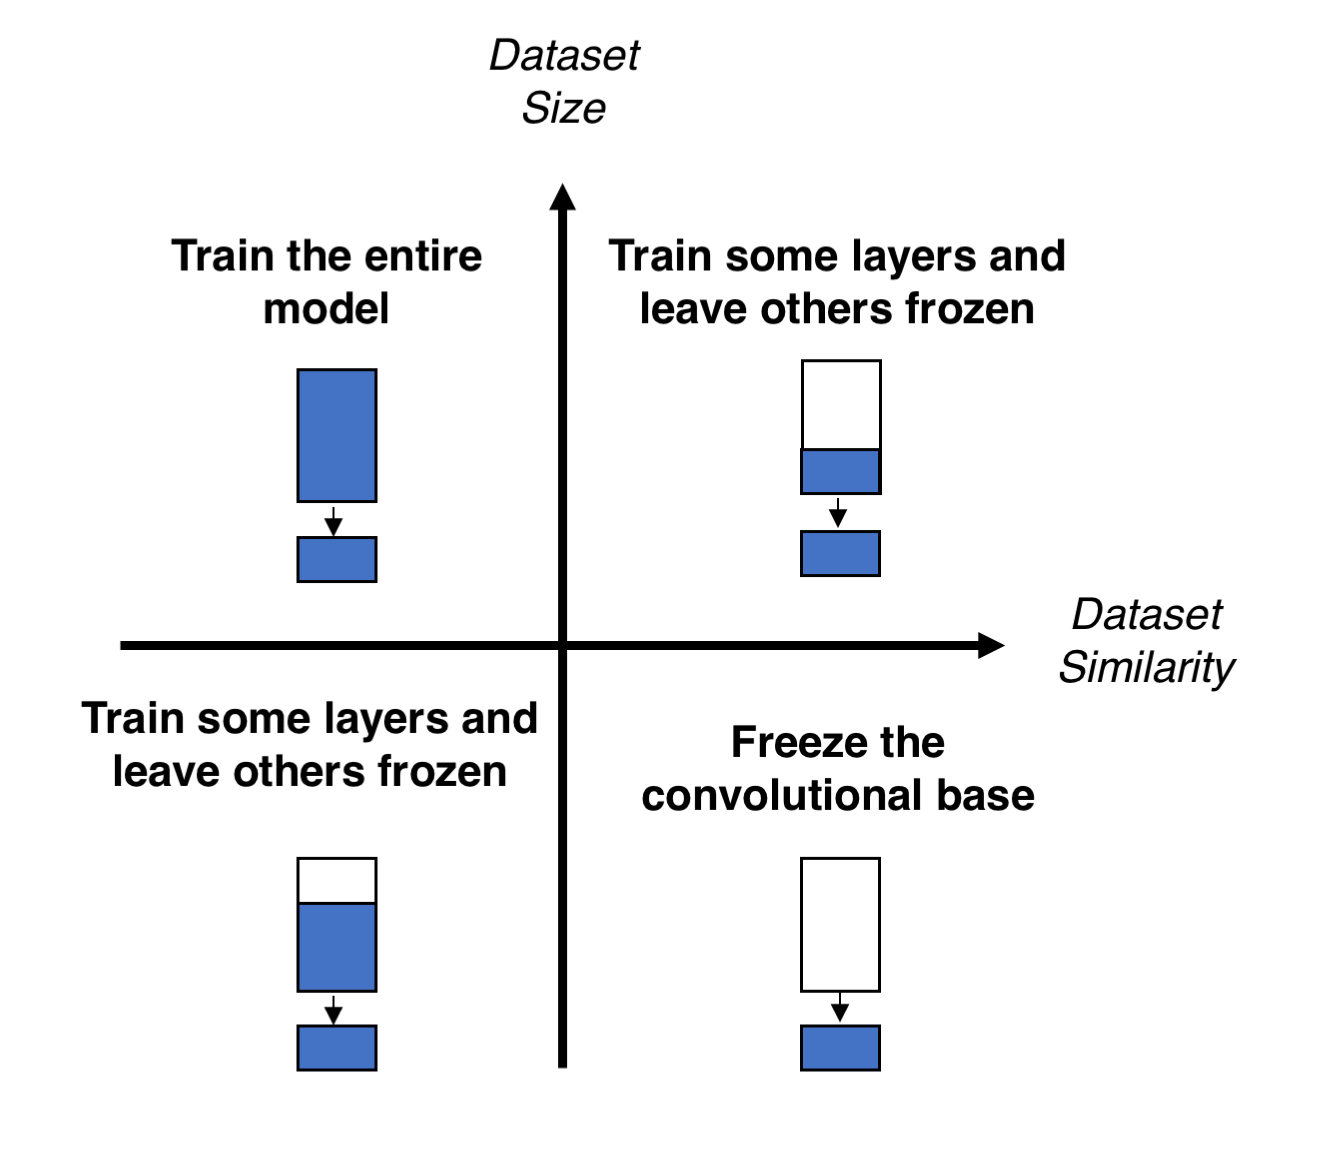

## - Import libaries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets, utils, models
from torch.utils.data import Dataset
from torchsummary import summary
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import time
import copy



## - Set GPU Envrionment

In [2]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

## - Set Hyper-parameters
  

In [3]:
# For Training
EPOCHS     = 4
BATCH_SIZE = 8

# For Optimizer
LR         = 0.001
MOMENTUM   = 0.9

## - Prepare the Dataset

http://ai.stanford.edu/~jkrause/cars/car_dataset.html

https://data.caltech.edu/records/mzrjq-6wc02

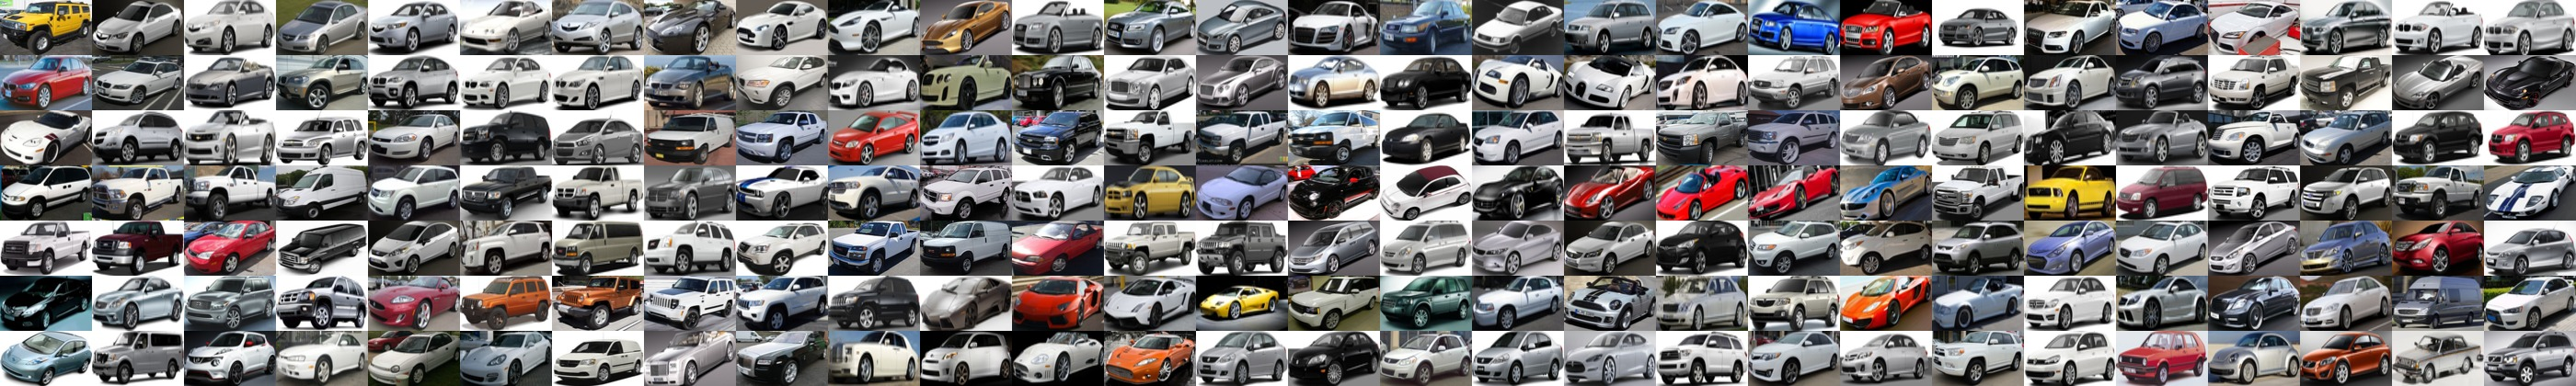

### - Split

In [4]:
STANFORDCARS_raw = datasets.StanfordCars(root='./dataset/STANFORDCARS', split='train', download=True, transform=transforms.ToTensor())

# 112 - Ford 45
# 113 - Ford 43

# 189 - Golf 46
# 190 - Golf 43

In [5]:
new_dataset_raw = []
for sample in STANFORDCARS_raw:
    if sample[1] == 112 or sample[1] == 113:
        new_dataset_raw.append([sample[0], 0])
    elif sample[1] == 189 or sample[1] == 190:
        new_dataset_raw.append([sample[0], 1])

print(len(new_dataset_raw))

dataset_sizes = len(new_dataset_raw)


177


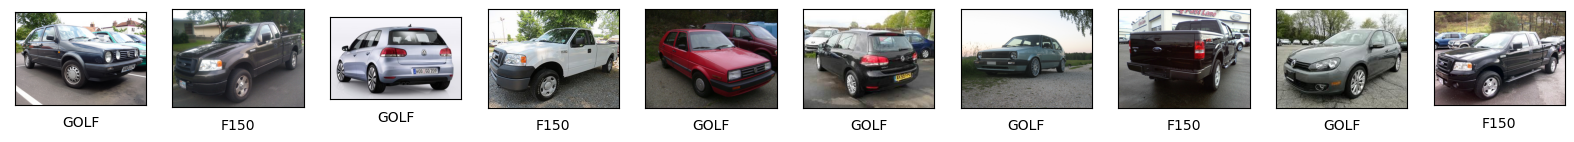

In [6]:
class_names = ['F150', 'GOLF']

np.random.seed(15)
torch.manual_seed(0)

grid_size = 10

plt.figure(figsize=(20,200))
for i in range(grid_size):
    plt.subplot(1,grid_size,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.array(new_dataset_raw[i][0]).transpose([1, 2, 0]))
    plt.xlabel(class_names[new_dataset_raw[i][1]])
plt.show()


## - Make CustomDataSet

In [7]:
class CustomDataset(Dataset): 
  def __init__(self, new_dataset_raw, transform):
    self.data = new_dataset_raw
    self.transform = transform

  def __len__(self): 
    return len(self.data)

  def __getitem__(self, idx): 
    x = self.transform(self.data[idx][0])
    y = torch.tensor(self.data[idx][1])
    return x, y


In [8]:

transform_CARS = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((255, 255)), 
    transforms.CenterCrop((224, 224)), 
    transforms.ToTensor(),
])

train_loader = torch.utils.data.DataLoader(
    CustomDataset(
        new_dataset_raw,
        transform = transform_CARS),
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory = True
)


## - Prepare a Model for Whole training

https://pytorch.org/vision/stable/models.html

In [11]:
model_ft = models.resnet18(weights='ResNet18_Weights.DEFAULT')

print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(DEVICE)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=LR, momentum=MOMENTUM)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [13]:
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## - Training the Whole Model

In [86]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in train_loader:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes
            epoch_acc = running_corrects.double() / dataset_sizes

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [141]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=EPOCHS)

Epoch 0/3
----------
train Loss: 0.1371 Acc: 0.9266
val Loss: 0.0101 Acc: 1.0000

Epoch 1/3
----------
train Loss: 0.0956 Acc: 0.9718
val Loss: 0.0073 Acc: 1.0000

Epoch 2/3
----------
train Loss: 0.0872 Acc: 0.9661
val Loss: 0.0019 Acc: 1.0000

Epoch 3/3
----------
train Loss: 0.0484 Acc: 0.9831
val Loss: 0.0007 Acc: 1.0000

Training complete in 1m 18s
Best val Acc: 1.000000


## - Predict and Visualize

In [142]:
def visualize(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    plt.figure(figsize=(20,200))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(1, num_images, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))

                plt.imshow(inputs[j].numpy().transpose([1,2,0]))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

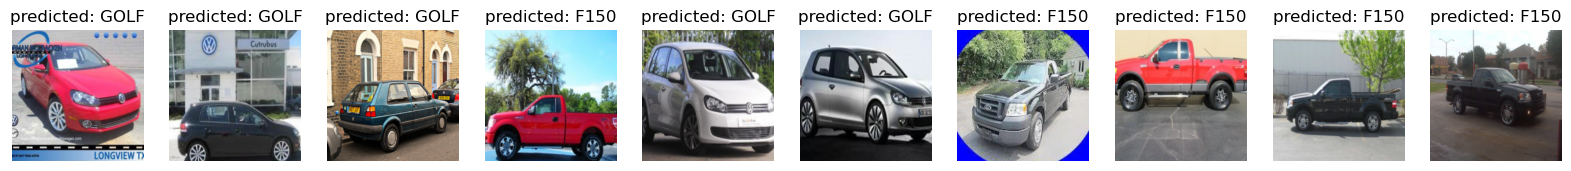

In [143]:
visualize(model_ft)

## - Prepare a Model for only Classifier Training (ConvNet as Fixed Feature Extractor)

https://pytorch.org/vision/stable/models.html

In [144]:
model_conv = models.resnet18(weights='ResNet18_Weights.DEFAULT')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(DEVICE)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=LR, momentum=MOMENTUM)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

## - Training only the Classifier

In [146]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=EPOCHS)

Epoch 0/3
----------
train Loss: 0.6422 Acc: 0.7119
val Loss: 0.2812 Acc: 0.8870

Epoch 1/3
----------
train Loss: 0.4381 Acc: 0.7910
val Loss: 0.1862 Acc: 0.9605

Epoch 2/3
----------
train Loss: 0.2812 Acc: 0.8814
val Loss: 0.1338 Acc: 0.9718

Epoch 3/3
----------
train Loss: 0.2458 Acc: 0.9040
val Loss: 0.1254 Acc: 0.9718

Training complete in 0m 48s
Best val Acc: 0.971751


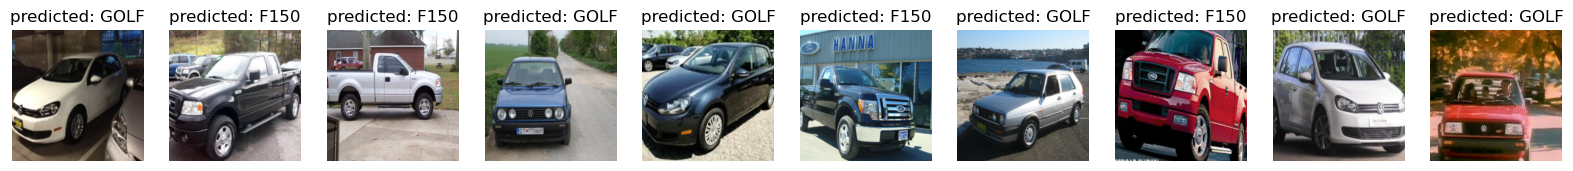

In [147]:
visualize(model_conv)

## - Save & Load

In [148]:
# Save model
torch.save(model_ft, 'transferresnet.pt')

In [149]:
# Load model
model = torch.load('transferresnet.pt')

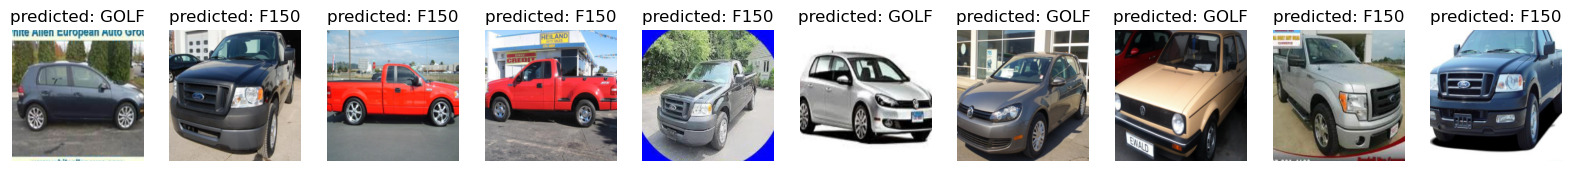

In [151]:
visualize(model)